# pvsystem tutorial

This tutorial explores the ``pvlib.pvsystem`` module. The module has functions for importing PV module and inverter data and functions for modeling module and inverter performance.

1. [systemdef](#systemdef)
2. [Angle of Incidence Modifiers](#Angle-of-Incidence-Modifiers)
2. [Sandia Cell Temp correction](#Sandia-Cell-Temp-correction)
2. [Sandia Inverter Model](#Sandia-inverter-model)
2. [Sandia Array Performance Model](#SAPM)
    1. [SAPM IV curves](#SAPM-IV-curves)
2. [DeSoto Model](#desoto)
2. [Single Diode Model](#Single-diode-model)

This tutorial has been tested against the following package versions:
* pvlib 0.4.5
* Python 3.6.2
* IPython 6.0
* Pandas 0.20.1

It should work with other Python and Pandas versions. It requires pvlib >= 0.4.0 and IPython >= 3.0.

Authors:
* Will Holmgren (@wholmgren), University of Arizona. 2015, March 2016, November 2016, May 2017.

In [1]:
# built-in python modules
import os
import inspect
import datetime

# scientific python add-ons
import numpy as np
import pandas as pd

# plotting stuff
# first line makes the plots appear in the notebook
%matplotlib inline 
import matplotlib.pyplot as plt
# seaborn makes your plots look better
try:
    import seaborn as sns
    sns.set(rc={"figure.figsize": (12, 6)})
except ImportError:
    print('We suggest you install seaborn using conda or pip and rerun this cell')

# finally, we import the pvlib library
import pvlib

### systemdef

In [2]:
import pvlib
from pvlib import pvsystem, inverter

``pvlib`` can import TMY2 and TMY3 data. Here, we import the example files.

In [3]:
pvlib_abspath = os.path.dirname(os.path.abspath(inspect.getfile(pvlib)))

tmy3_data, tmy3_metadata = pvlib.iotools.read_tmy3(os.path.join(pvlib_abspath, 'data', '703165TY.csv'))
tmy2_data, tmy2_metadata = pvlib.iotools.read_tmy2(os.path.join(pvlib_abspath, 'data', '12839.tm2'))

In [4]:
pvlib.pvsystem.systemdef(tmy3_metadata, 0, 0, .1, 5, 5)

{'surface_tilt': 0,
 'surface_azimuth': 0,
 'albedo': 0.1,
 'modules_per_string': 5,
 'strings_per_inverter': 5,
 'latitude': 55.317,
 'longitude': -160.517,
 'tz': -9.0,
 'name': '"SAND POINT"',
 'altitude': 7.0}

In [5]:
pvlib.pvsystem.systemdef(tmy2_metadata, 0, 0, .1, 5, 5)

{'surface_tilt': 0,
 'surface_azimuth': 0,
 'albedo': 0.1,
 'modules_per_string': 5,
 'strings_per_inverter': 5,
 'latitude': 25.8,
 'longitude': -80.26666666666667,
 'tz': -5,
 'name': 'MIAMI',
 'altitude': 2.0}

### Angle of Incidence Modifiers

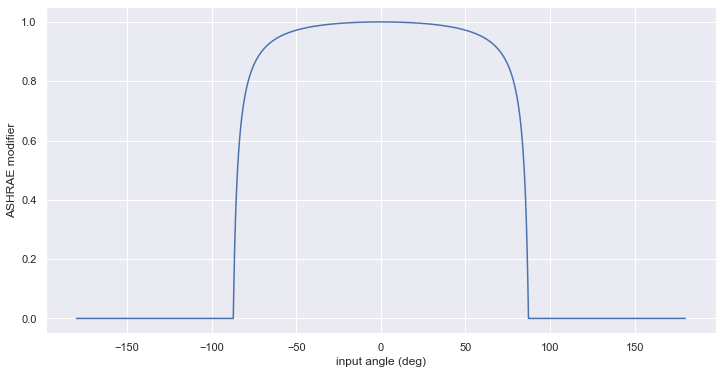

In [6]:
angles = np.linspace(-180,180,3601)
ashraeiam = pd.Series(pvsystem.iam.ashrae(angles, .05), index=angles)

ashraeiam.plot()
plt.ylabel('ASHRAE modifier')
plt.xlabel('input angle (deg)');

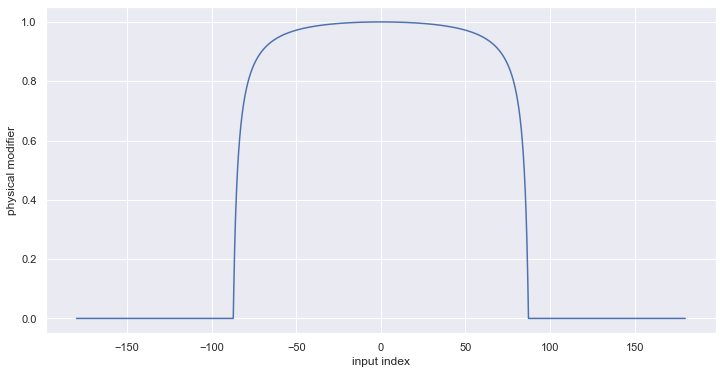

In [7]:
angles = np.linspace(-180,180,3601)
physicaliam = pd.Series(pvsystem.iam.ashrae(angles), index=angles)

physicaliam.plot()
plt.ylabel('physical modifier')
plt.xlabel('input index');

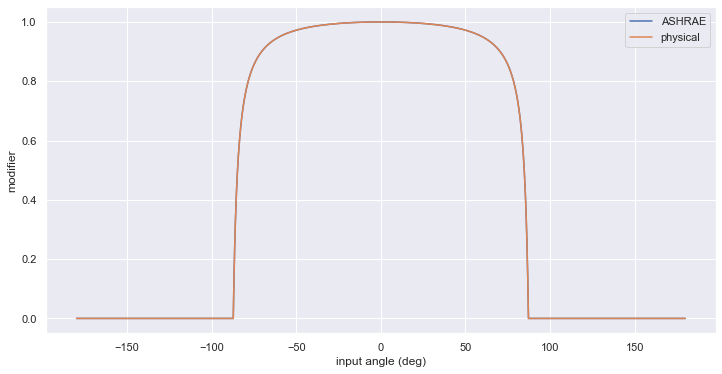

In [8]:
plt.figure()
ashraeiam.plot(label='ASHRAE')
physicaliam.plot(label='physical')
plt.ylabel('modifier')
plt.xlabel('input angle (deg)')
plt.legend();

### Sandia Cell Temp correction

PV system efficiency can vary by up to 0.5% per degree C, so it's important to accurately model cell temperature. The ``temperature.sapm_cell`` function uses plane of array irradiance, ambient temperature, wind speed, and module and racking type to calculate cell temperature. From King et. al. (2004):

$$T_m = E e^{a+b*WS} + T_a$$

$$T_c = T_m + \frac{E}{E_0} \Delta T$$

The $a$, $b$, and $\Delta T$ parameters depend on the module and racking type. Here we use the ``open_rack_glass_glass`` parameters.

``sapm_cell`` works with either scalar or vector inputs.

In [9]:
# scalar inputs
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
pvlib.temperature.sapm_cell(900, 20, 5, **thermal_params) # irrad, temp, wind

43.509190983665746

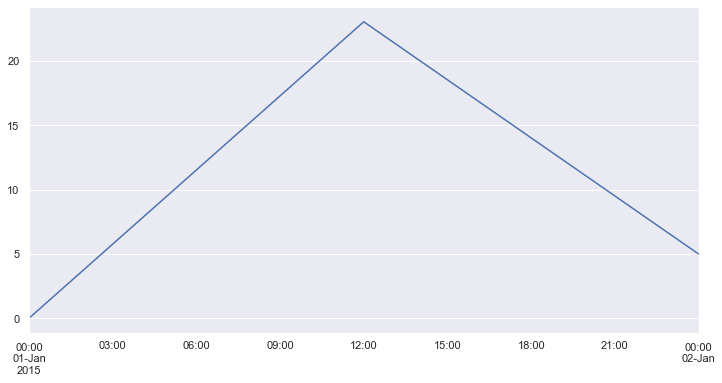

In [10]:
# vector inputs
times = pd.date_range(start='2015-01-01', end='2015-01-02', freq='12H')
temps = pd.Series([0, 10, 5], index=times)
irrads = pd.Series([0, 500, 0], index=times)
winds = pd.Series([10, 5, 0], index=times)

pvtemps = pvlib.temperature.sapm_cell(irrads, temps, winds, **thermal_params)
pvtemps.plot();

Cell temperature as a function of wind speed.

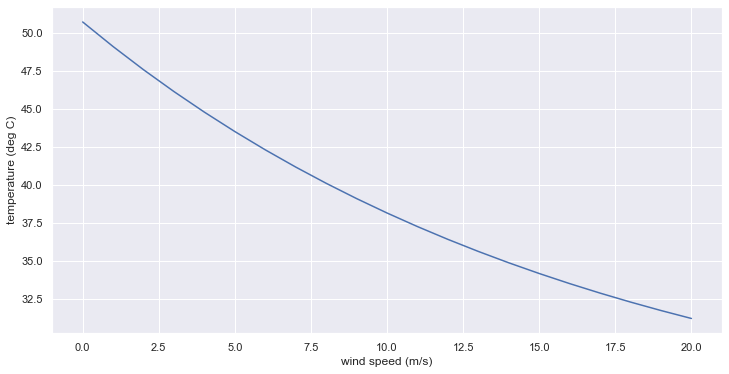

In [11]:
wind = np.linspace(0,20,21)
temps = pd.Series(pvlib.temperature.sapm_cell(900, 20, wind, **thermal_params), index=wind)

temps.plot()
plt.xlabel('wind speed (m/s)')
plt.ylabel('temperature (deg C)');

Cell temperature as a function of ambient temperature.

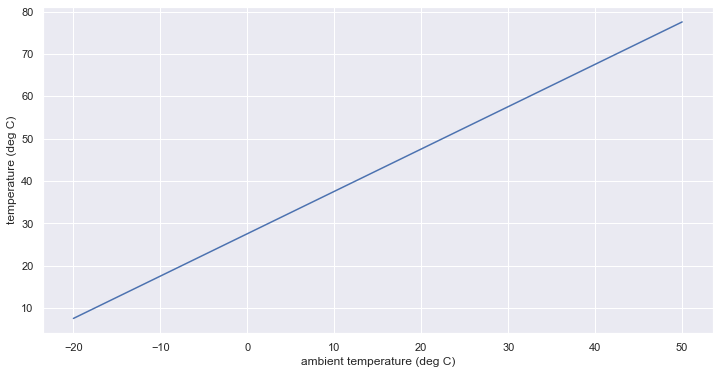

In [12]:
atemp = np.linspace(-20,50,71)
temps = pd.Series(pvlib.temperature.sapm_cell(900, atemp, 2, **thermal_params), index=atemp)

temps.plot()
plt.xlabel('ambient temperature (deg C)')
plt.ylabel('temperature (deg C)');

Cell temperature as a function of incident irradiance.

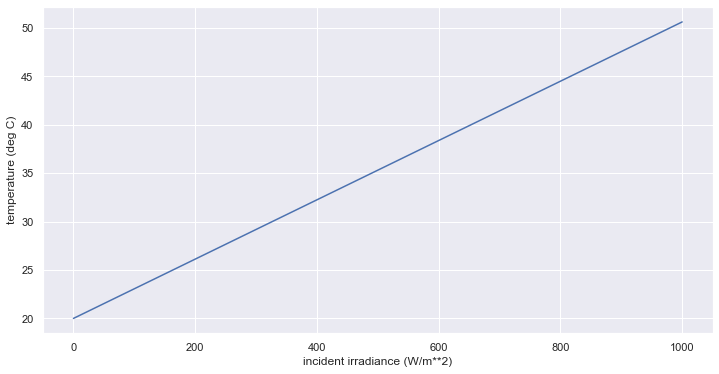

In [13]:
irrad = np.linspace(0,1000,101)
temps = pd.Series(pvlib.temperature.sapm_cell(irrad, 20, 2, **thermal_params), index=irrad)

temps.plot()
plt.xlabel('incident irradiance (W/m**2)')
plt.ylabel('temperature (deg C)');

Cell temperature for different module and racking types.

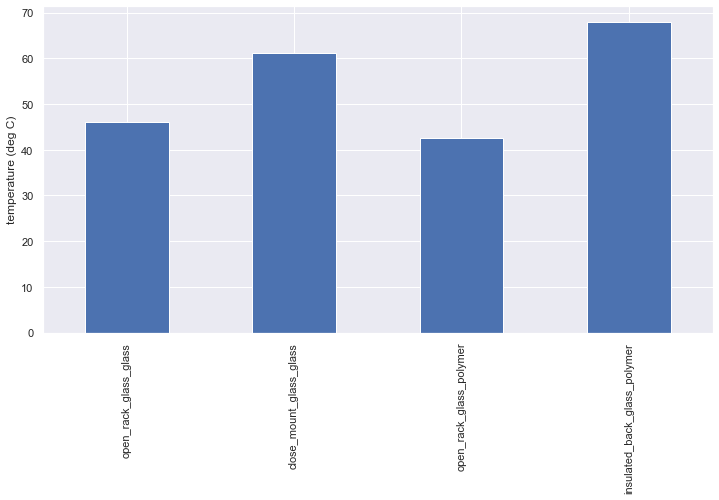

In [14]:
models = ['open_rack_glass_glass',
          'close_mount_glass_glass',
          'open_rack_glass_polymer',
          'insulated_back_glass_polymer']

temps = pd.Series(dtype=float)

for model in models:
    params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm'][model]
    temps[model] = pvlib.temperature.sapm_cell(1000, 20, 5, **params)

temps.plot(kind='bar')
plt.ylabel('temperature (deg C)');

### Sandia-inverter-model

In [15]:
inverters = pvsystem.retrieve_sam('sandiainverter')
inverters

,ABB__MICRO_0_25_I_OUTD_US_208__208V_,ABB__MICRO_0_25_I_OUTD_US_240__240V_,ABB__MICRO_0_3_I_OUTD_US_208__208V_,ABB__MICRO_0_3_I_OUTD_US_240__240V_,ABB__MICRO_0_3HV_I_OUTD_US_208__208V_,ABB__MICRO_0_3HV_I_OUTD_US_240__240V_,ABB__PVI_10_0_I_OUTD_x_US_208_y__208V_,ABB__PVI_10_0_I_OUTD_x_US_480_y_z__480V_,ABB__PVI_12_0_I_OUTD_x_US_480_y__480V_,ABB__PVI_3_0_OUTD_S_US__208V_,...,Zigor__Sunzet_3_TL_US__240V_,i_Energy__GT260__240V_,iPower__SHO_1_1__120V_,iPower__SHO_2_0__240V_,iPower__SHO_2_5__240V_,iPower__SHO_3_0__240V_,iPower__SHO_3_5__240V_,iPower__SHO_4_6__208V_,iPower__SHO_4_8__240V_,iPower__SHO_5_2__240V_
Vac,208,240,208,240,208,240,208,480,480,208,...,240,240,120,240,240,240,240,208,240,240
Pso,2.08961,2.24041,1.84651,1.95054,1.76944,1.84378,46.8638,67.7909,62.5547,18.1663,...,36.0334,2.5301,22.0954,24.4658,42.7765,31.682,64.7742,54.5701,85.1457,62.4867
Paco,250,250,300,300,300,300,10000,10000,12000,3000,...,3180,230,1100,2000,2500,3000,3500,4600,4800,5200
Pdco,259.589,259.492,311.669,311.581,312.421,312.005,10488.3,10296,12358.8,3142.3,...,3315.65,245.63,1194.09,2161.88,2632.84,3205.93,3641.84,4797.81,4968.03,5382.86
Vdco,40,40,40,40,45,45,320,362,370,310,...,375,40,182,199,218,222.5,263,254,263,280
C0,-4.1e-05,-3.9e-05,-3.3e-05,-3.4e-05,-4.5e-05,-3.5e-05,-2.7759e-06,-1.38839e-06,-1.009e-06,-8.03949e-06,...,-7.98467e-06,6.2e-05,-2.1e-05,-1.3e-05,-1.4e-05,-8.21046e-06,-9.08073e-06,-5.99928e-06,-6.16035e-06,-4.63524e-06
C1,-9.1e-05,-0.000132,-0.000192,-0.000256,-0.000196,-0.000227,-3.6e-05,-4.9e-05,-5.6e-05,-1.1e-05,...,-7.5e-05,-9.8e-05,5.7e-05,5.5e-05,6.1e-05,3.6e-05,3.5e-05,2.8e-05,3.4e-05,4.4e-05
C2,0.000494,0.002418,0.000907,0.002453,0.001959,-0.000526,0.000305,-0.00052,-0.001437,0.000999,...,0.000544,0.000231,0.002001,0.001703,0.002053,0.001708,0.001417,0.001381,0.000586,0.00126
C3,-0.013171,-0.014926,-0.031742,-0.028223,-0.023725,-0.041214,-0.002351,-0.003855,-0.007112,-0.000287,...,-0.000338,0.121032,0.000623,0.000315,0.00153,0.00086,0.001218,0.000889,0.000195,0.000367
Pnt,0.075,0.075,0.09,0.09,0.09,0.09,0.1,0.4,0.4,0.1,...,0.954,0.069,0.33,0.6,0.75,0.9,1.05,1.38,1.44,1.56


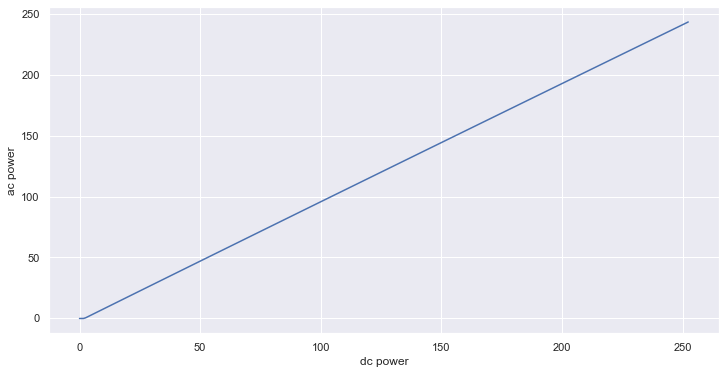

In [16]:
vdcs = pd.Series(np.linspace(0,50,51))
idcs = pd.Series(np.linspace(0,11,110))
pdcs = idcs * vdcs

pacs = inverter.sandia(vdcs, pdcs, inverters['ABB__MICRO_0_25_I_OUTD_US_208__208V_'])
#pacs.plot()
plt.plot(pdcs, pacs)
plt.ylabel('ac power')
plt.xlabel('dc power');

Need to put more effort into describing this function.

### DC model

This example shows use of the Desoto module performance model and the Sandia Array Performance Model (SAPM). Both models reuire a set of parameter values which can be read from SAM databases for modules.

Foe the Desoto model, the database content is returned by supplying the keyword `cecmod` to `pvsystem.retrievesam`.

In [17]:
cec_modules = pvsystem.retrieve_sam('cecmod')
cec_modules

,A10Green_Technology_A10J_S72_175,A10Green_Technology_A10J_S72_180,A10Green_Technology_A10J_S72_185,A10Green_Technology_A10J_M60_220,A10Green_Technology_A10J_M60_225,A10Green_Technology_A10J_M60_230,A10Green_Technology_A10J_M60_235,A10Green_Technology_A10J_M60_240,A2Peak_Power_POWER_ON_P220_6x10,Aavid_Solar_ASMS_165P,...,Zytech_Solar_ZT275P,Zytech_Solar_ZT280P,Zytech_Solar_ZT285P,Zytech_Solar_ZT290P,Zytech_Solar_ZT295P,Zytech_Solar_ZT300P,Zytech_Solar_ZT305P,Zytech_Solar_ZT310P,Zytech_Solar_ZT315P,Zytech_Solar_ZT320P
Technology,Mono-c-Si,Mono-c-Si,Mono-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,...,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si,Multi-c-Si
Bifacial,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
STC,175.091,179.928,184.702,219.876,224.986,230.129,235.008,240.538,219.978,164.85,...,275.014,280.329,285.326,290.036,295.066,300.003,305.056,310.144,315.094,320.42
PTC,151.2,155.7,160.2,189.1,193.5,204.1,208.7,213.3,195,146.3,...,248,252.6,257.3,261.9,266.5,271.2,275.8,280.5,285.1,289.8
A_c,1.3,1.3,1.3,1.624,1.624,1.624,1.624,1.624,1.633,1.301,...,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931,1.931
Length,1.576,1.576,1.576,1.632,1.632,1.632,1.632,1.632,1.633,1.575,...,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95,1.95
Width,0.825,0.825,0.825,0.995,0.995,0.995,0.995,0.995,1,0.826,...,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99,0.99
N_s,72,72,72,60,60,60,60,60,60,72,...,72,72,72,72,72,72,72,72,72,72
I_sc_ref,5.17,5.31,5.43,7.95,8.04,8.1,8.23,8.32,7.98,5.25,...,8.31,8.4,8.48,8.55,8.64,8.71,8.87,8.9,9.01,9.12
V_oc_ref,43.99,44.06,44.14,36.06,36.24,36.42,36.72,36.84,36.72,43.5,...,45.1,45.25,45.43,45.59,45.75,45.96,46.12,46.28,46.44,46.6


In [18]:
cecmodule = cec_modules.Canadian_Solar_Inc__CS5P_220M 
cecmodule

Technology            Mono-c-Si
Bifacial                      0
STC                     219.961
PTC                       200.1
A_c                         1.7
Length                    1.602
Width                     1.061
N_s                          96
I_sc_ref                    5.1
V_oc_ref                   59.4
I_mp_ref                   4.69
V_mp_ref                   46.9
alpha_sc               0.004539
beta_oc               -0.222156
T_NOCT                     42.4
a_ref                   2.63593
I_L_ref                 5.11426
I_o_ref             8.10251e-10
R_s                     1.06602
R_sh_ref                381.254
Adjust                  8.61952
gamma_r                  -0.476
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS5P_220M, dtype: object

The Sandia module database is read by the same function with the keyword `SandiaMod`.

In [19]:
sandia_modules = pvsystem.retrieve_sam(name='SandiaMod')
sandia_modules

,Advent_Solar_AS160___2006_,Advent_Solar_Ventura_210___2008_,Advent_Solar_Ventura_215___2009_,Aleo_S03_160__2007__E__,Aleo_S03_165__2007__E__,Aleo_S16_165__2007__E__,Aleo_S16_170__2007__E__,Aleo_S16_175__2007__E__,Aleo_S16_180__2007__E__,Aleo_S16_185__2007__E__,...,Panasonic_VBHN235SA06B__2013_,Trina_TSM_240PA05__2013_,Hanwha_HSL60P6_PA_4_250T__2013_,Suniva_OPT300_72_4_100__2013_,Canadian_Solar_CS6X_300M__2013_,LG_LG290N1C_G3__2013_,Sharp_NDQ235F4__2013_,Solar_Frontier_SF_160S__2013_,SolarWorld_Sunmodule_250_Poly__2013_,Silevo_Triex_U300_Black__2014_
Vintage,2006,2008,2009,2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),2007 (E),...,2013,2013,2013,2013,2013,2013,2013,2013,2013,2014
Area,1.312,1.646,1.646,1.28,1.28,1.378,1.378,1.378,1.378,1.378,...,1.26,1.63,1.65,1.93,1.91,1.64,1.56,1.22,1.68,1.68
Material,mc-Si,mc-Si,mc-Si,c-Si,c-Si,mc-Si,mc-Si,mc-Si,mc-Si,mc-Si,...,a-Si / mono-Si,mc-Si,mc-Si,c-Si,c-Si,c-Si,mc-Si,CIS,mc-Si,c-Si
Cells_in_Series,72,60,60,72,72,50,50,50,50,50,...,72,60,60,72,72,60,60,172,60,96
Parallel_Strings,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
Isco,5.564,8.34,8.49,5.1,5.2,7.9,7.95,8.1,8.15,8.2,...,5.8738,8.8449,8.5935,8.5753,8.6388,9.8525,8.6739,2.0259,8.3768,5.771
Voco,42.832,35.31,35.92,43.5,43.6,30,30.1,30.2,30.3,30.5,...,52.0042,36.8926,36.8075,44.2921,43.5918,39.6117,36.8276,112.505,36.3806,68.5983
Impo,5.028,7.49,7.74,4.55,4.65,7.08,7.23,7.38,7.53,7.67,...,5.5383,8.2955,8.0822,7.963,8.1359,9.2473,8.1243,1.8356,7.6921,5.383
Vmpo,32.41,27.61,27.92,35.6,35.8,23.3,23.5,23.7,23.9,24.1,...,43.1204,29.066,29.2011,35.0837,34.9531,31.2921,29.1988,86.6752,28.348,55.4547
Aisc,0.000537,0.00077,0.00082,0.0003,0.0003,0.0008,0.0008,0.0008,0.0008,0.0008,...,0.0005,0.0004,0.0004,0.0006,0.0005,0.0002,0.0006,0.0001,0.0006,0.0003


In [20]:
sandia_module = sandia_modules.Canadian_Solar_CS5P_220M___2009_
sandia_module

Vintage                                                          2009
Area                                                            1.701
Material                                                         c-Si
Cells_in_Series                                                    96
Parallel_Strings                                                    1
Isco                                                          5.09115
Voco                                                          59.2608
Impo                                                          4.54629
Vmpo                                                          48.3156
Aisc                                                         0.000397
Aimp                                                         0.000181
C0                                                            1.01284
C1                                                         -0.0128398
Bvoco                                                        -0.21696
Mbvoc               

Generate some irradiance data for modeling.

In [21]:
from pvlib import clearsky
from pvlib import irradiance
from pvlib import atmosphere
from pvlib.location import Location

tus = Location(32.2, -111, 'US/Arizona', 700, 'Tucson')

times_loc = pd.date_range(start=datetime.datetime(2014,4,1), end=datetime.datetime(2014,4,2), freq='30s', tz=tus.tz)
solpos = pvlib.solarposition.get_solarposition(times_loc, tus.latitude, tus.longitude)
dni_extra = pvlib.irradiance.get_extra_radiation(times_loc)
airmass = pvlib.atmosphere.get_relative_airmass(solpos['apparent_zenith'])
pressure = pvlib.atmosphere.alt2pres(tus.altitude)
am_abs = pvlib.atmosphere.get_absolute_airmass(airmass, pressure)
cs = tus.get_clearsky(times_loc)

surface_tilt = tus.latitude
surface_azimuth = 180  # pointing south

aoi = pvlib.irradiance.aoi(surface_tilt, surface_azimuth,
                           solpos['apparent_zenith'], solpos['azimuth'])
total_irrad = pvlib.irradiance.get_total_irradiance(surface_tilt,
                                                    surface_azimuth,
                                                    solpos['apparent_zenith'],
                                                    solpos['azimuth'],
                                                    cs['dni'], cs['ghi'], cs['dhi'],
                                                    dni_extra=dni_extra,
                                                    model='haydavies')

Now we can run the module parameters and the irradiance data through the SAPM functions.

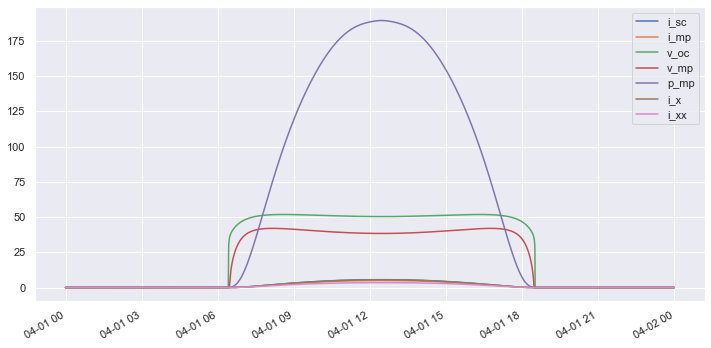

In [22]:
module = sandia_module

# a sunny, calm, and hot day in the desert
thermal_params = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS['sapm']['open_rack_glass_glass']
temps = pvlib.temperature.sapm_cell(total_irrad['poa_global'], 30, 0, **thermal_params)

effective_irradiance = pvlib.pvsystem.sapm_effective_irradiance(
    total_irrad['poa_direct'], total_irrad['poa_diffuse'],
    am_abs, aoi, module)

sapm_1 = pvlib.pvsystem.sapm(effective_irradiance, temps, module)

sapm_1.plot();

In [23]:
def plot_sapm(sapm_data, effective_irradiance):
    """
    Makes a nice figure with the SAPM data.
    
    Parameters
    ----------
    sapm_data : DataFrame
        The output of ``pvsystem.sapm``
    """
    fig, axes = plt.subplots(2, 3, figsize=(16,10), sharex=False, sharey=False, squeeze=False)
    plt.subplots_adjust(wspace=.2, hspace=.3)

    ax = axes[0,0]
    sapm_data.filter(like='i_').plot(ax=ax)
    ax.set_ylabel('Current (A)')

    ax = axes[0,1]
    sapm_data.filter(like='v_').plot(ax=ax)
    ax.set_ylabel('Voltage (V)')

    ax = axes[0,2]
    sapm_data.filter(like='p_').plot(ax=ax)
    ax.set_ylabel('Power (W)')

    ax = axes[1,0]
    [ax.plot(effective_irradiance, current, label=name) for name, current in
     sapm_data.filter(like='i_').iteritems()]
    ax.set_ylabel('Current (A)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    ax = axes[1,1]
    [ax.plot(effective_irradiance, voltage, label=name) for name, voltage in
     sapm_data.filter(like='v_').iteritems()]
    ax.set_ylabel('Voltage (V)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=4)

    ax = axes[1,2]
    ax.plot(effective_irradiance, sapm_data['p_mp'], label='p_mp')
    ax.set_ylabel('Power (W)')
    ax.set_xlabel('Effective Irradiance')
    ax.legend(loc=2)

    # needed to show the time ticks
    for ax in axes.flatten():
        for tk in ax.get_xticklabels():
            tk.set_visible(True)

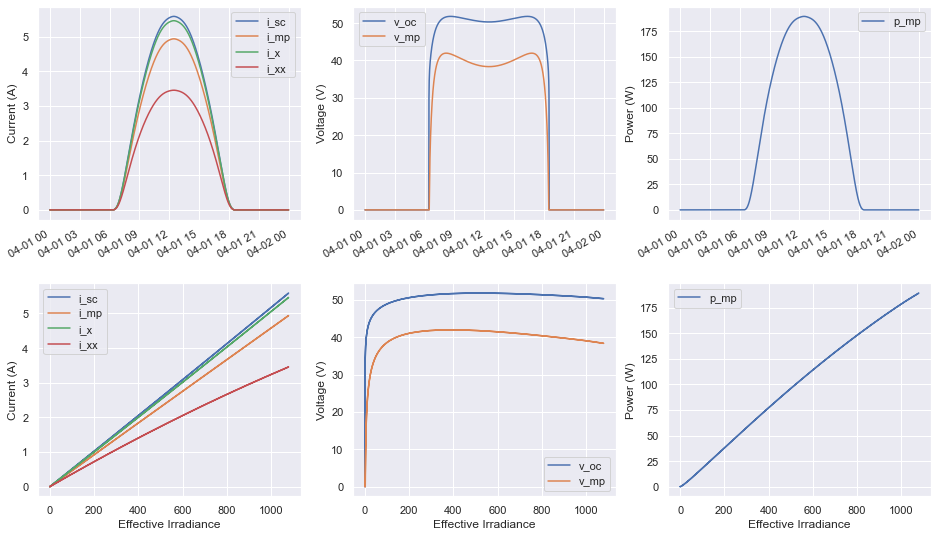

In [24]:
plot_sapm(sapm_1, effective_irradiance)

For comparison, here's the SAPM for a sunny, windy, cold version of the same day.

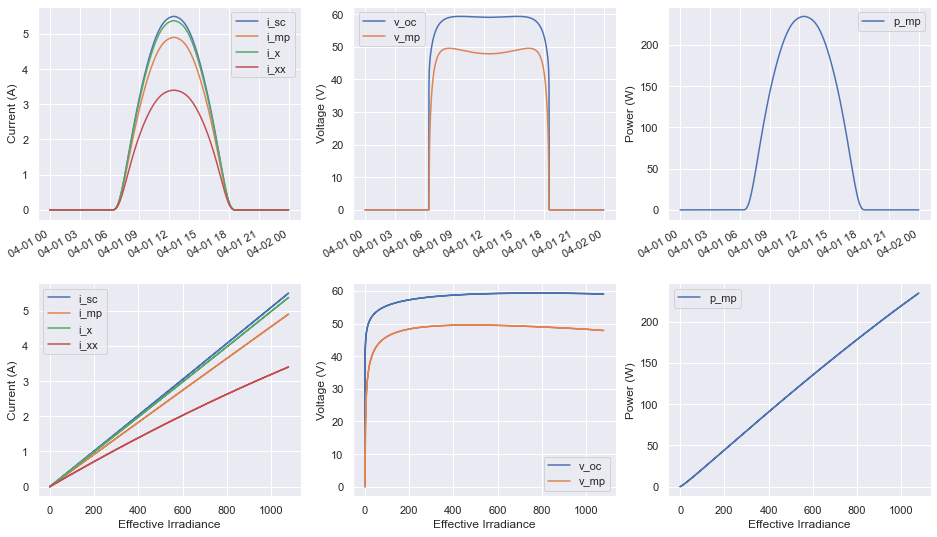

In [25]:
temps = pvlib.temperature.sapm_cell(total_irrad['poa_global'], 5, 10, **thermal_params)

sapm_2 = pvlib.pvsystem.sapm(effective_irradiance, temps, module)

plot_sapm(sapm_2, effective_irradiance)

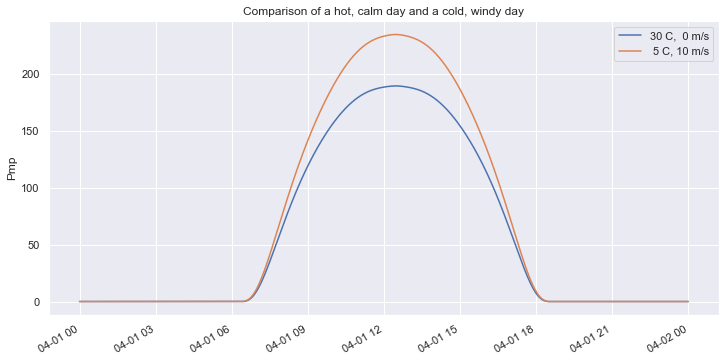

In [26]:
sapm_1['p_mp'].plot(label='30 C,  0 m/s')
sapm_2['p_mp'].plot(label=' 5 C, 10 m/s')
plt.legend()
plt.ylabel('Pmp')
plt.title('Comparison of a hot, calm day and a cold, windy day');

#### SAPM IV curves

The IV curve function only calculates the 5 points of the SAPM. We will add arbitrary points in a future release, but for now we just interpolate between the 5 SAPM points.

In [27]:
import warnings
warnings.simplefilter('ignore', np.RankWarning)

In [28]:
def sapm_to_ivframe(sapm_row):
    pnt = sapm_row

    ivframe = {'Isc': (pnt['i_sc'], 0),
              'Pmp': (pnt['i_mp'], pnt['v_mp']),
              'Ix': (pnt['i_x'], 0.5*pnt['v_oc']),
              'Ixx': (pnt['i_xx'], 0.5*(pnt['v_oc']+pnt['v_mp'])),
              'Voc': (0, pnt['v_oc'])}
    ivframe = pd.DataFrame(ivframe, index=['current', 'voltage']).T
    ivframe = ivframe.sort_values(by='voltage')
    
    return ivframe

def ivframe_to_ivcurve(ivframe, points=100):
    ivfit_coefs = np.polyfit(ivframe['voltage'], ivframe['current'], 30)
    fit_voltages = np.linspace(0, ivframe.loc['Voc', 'voltage'], points)
    fit_currents = np.polyval(ivfit_coefs, fit_voltages)
    
    return fit_voltages, fit_currents

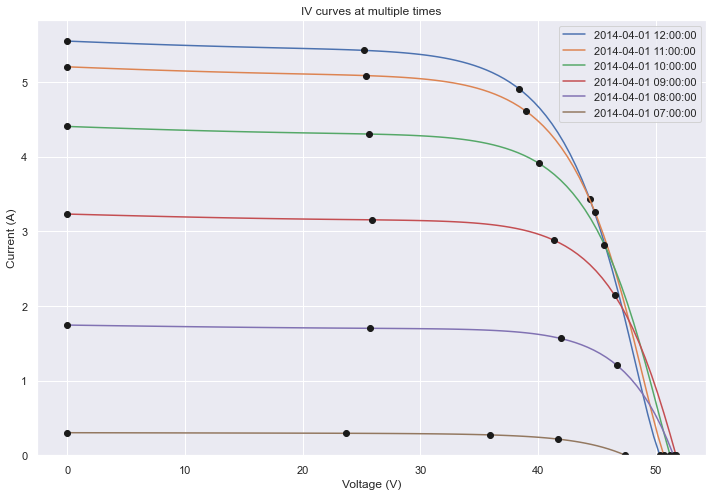

In [29]:
times = ['2014-04-01 07:00:00', '2014-04-01 08:00:00', '2014-04-01 09:00:00', 
         '2014-04-01 10:00:00', '2014-04-01 11:00:00', '2014-04-01 12:00:00']
times.reverse()

fig, ax = plt.subplots(1, 1, figsize=(12,8))

for time in times:
    ivframe = sapm_to_ivframe(sapm_1.loc[time])

    fit_voltages, fit_currents = ivframe_to_ivcurve(ivframe)

    ax.plot(fit_voltages, fit_currents, label=time)
    ax.plot(ivframe['voltage'], ivframe['current'], 'ko')
    
ax.set_xlabel('Voltage (V)')
ax.set_ylabel('Current (A)')
ax.set_ylim(0, None)
ax.set_title('IV curves at multiple times')
ax.legend();

### desoto

The same weather data run through the Desoto model.

In [30]:
photocurrent, saturation_current, resistance_series, resistance_shunt, nNsVth = (
    pvsystem.calcparams_desoto(total_irrad['poa_global'],
                               temp_cell=temps,
                               alpha_sc=cecmodule['alpha_sc'],
                               a_ref=cecmodule['a_ref'],
                               I_L_ref=cecmodule['I_L_ref'],
                               I_o_ref=cecmodule['I_o_ref'],
                               R_sh_ref=cecmodule['R_sh_ref'],
                               R_s=cecmodule['R_s']) )

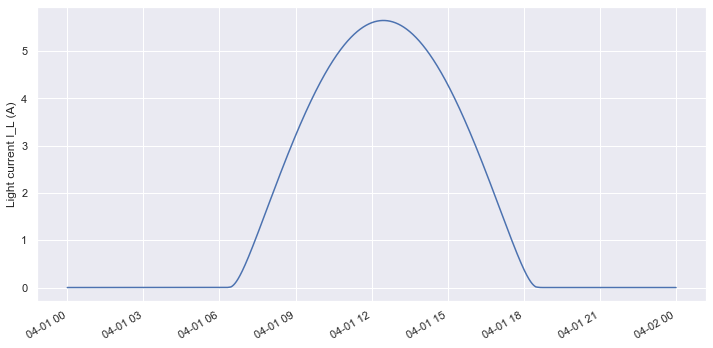

In [31]:
photocurrent.plot()
plt.ylabel('Light current I_L (A)');

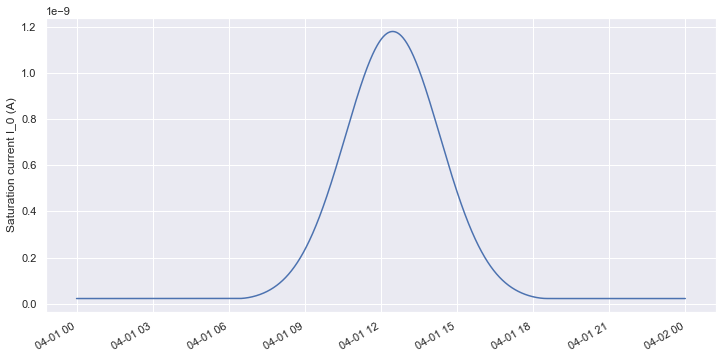

In [32]:
saturation_current.plot()
plt.ylabel('Saturation current I_0 (A)');

In [33]:
resistance_series

1.066023

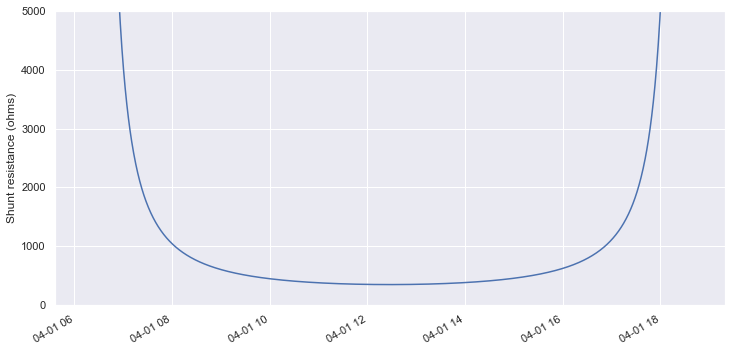

In [34]:
resistance_shunt.plot()
plt.ylabel('Shunt resistance (ohms)')
plt.ylim(0, 5000);

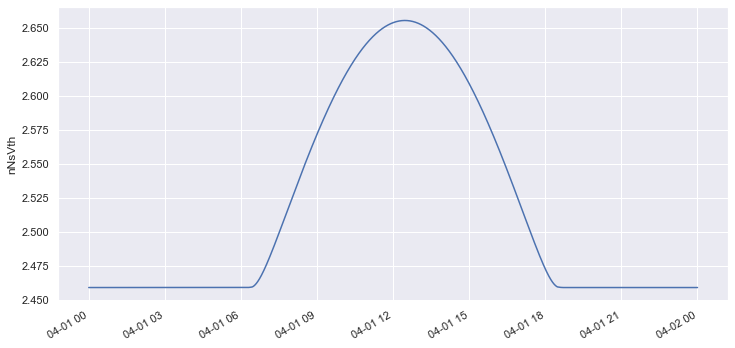

In [35]:
nNsVth.plot()
plt.ylabel('nNsVth');

### Single diode model

In [36]:
single_diode_out = pvsystem.singlediode(photocurrent, saturation_current,
                                        resistance_series, resistance_shunt, nNsVth)

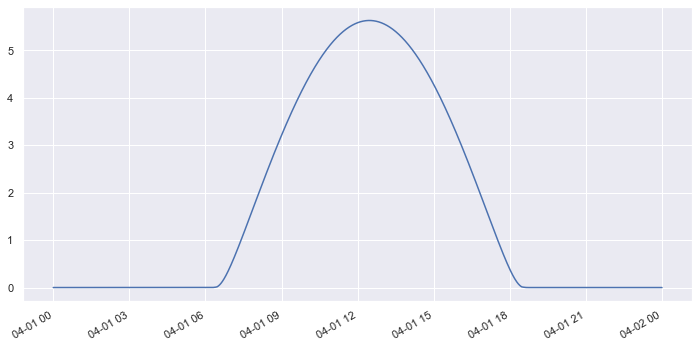

In [37]:
single_diode_out['i_sc'].plot();

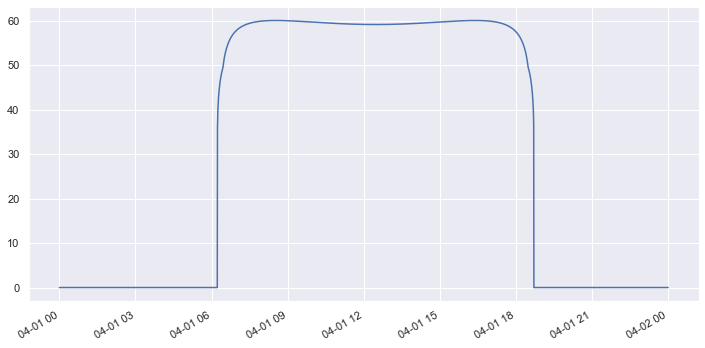

In [38]:
single_diode_out['v_oc'].plot();

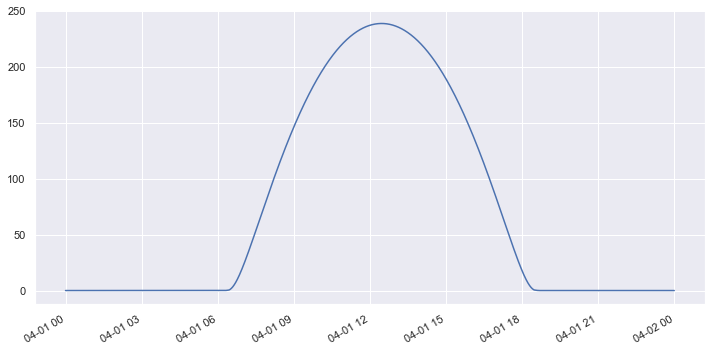

In [39]:
single_diode_out['p_mp'].plot();